In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


#load data
train_df = pd.read_csv("train_split_merged_expanded_data.csv")
val_df = pd.read_csv("val_split_merged_expanded_data.csv")
test_df = pd.read_csv("test_split_merged_expanded_data.csv")

#datetime features
train_df['date'] = pd.to_datetime(train_df['date'])
val_df['date'] = pd.to_datetime(val_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

for df in [train_df, val_df, test_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df.drop('date', axis=1, inplace=True)

for df in [train_df, val_df, test_df]:
    df = pd.get_dummies(df, columns=['weekday'], prefix='wd')

all_columns = set(train_df.columns) | set(val_df.columns) | set(test_df.columns)

for df in [train_df, val_df, test_df]:
    for col in all_columns:
        if col not in df.columns:
            df[col] = 0

train_df = train_df[sorted(train_df.columns)]
val_df   = val_df[sorted(val_df.columns)]
test_df  = test_df[sorted(test_df.columns)]


#prepare data
X_train = train_df.drop(columns=['umsatz'])
y_train = train_df['umsatz']
X_val = val_df.drop(columns=['umsatz'])
y_val = val_df['umsatz']
X_test = test_df.drop(columns=['umsatz'])
y_test = test_df['umsatz']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#define model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#train model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val))

#evaluate model
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

#save model
model.save('neural_network_model_classification.h5')

c:\Users\lonep\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
c:\Users\lonep\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0000e+00 - loss: -513588.4375 - val_accuracy: 0.0000e+00 - val_loss: -2470414.5000
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: -20653012.0000 - val_accuracy: 0.0000e+00 - val_loss: -45279780.0000
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: -159196672.0000 - val_accuracy: 0.0000e+00 - val_loss: -236457952.0000
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: -606311808.0000 - val_accuracy: 0.0000e+00 - val_loss: -724151296.0000
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: -1598188160.0000 - val_accuracy: 0.0000e+00 - val_loss: -1681116672.0000
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: -3404707072.0000 - val_accuracy: 0.0000e+00 - val_loss: -3293552896.0000
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+

Validation Loss: -31866298040320.0, Validation Accuracy: 0.0


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\lonep\AppData\Local\Temp\ipykernel_42468\2937089369.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


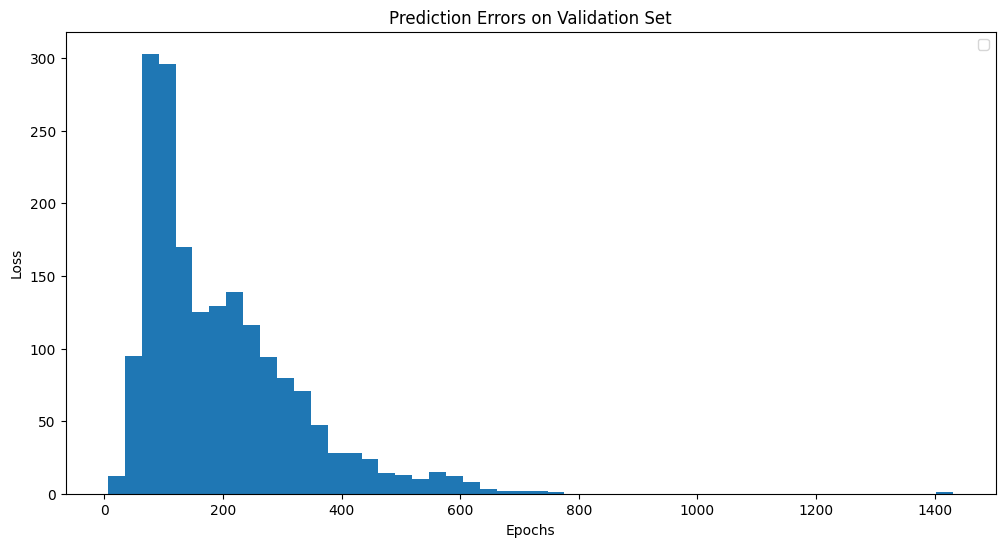

In [3]:
#visualize training history
import matplotlib.pyplot as plt

errors = y_val - model.predict(X_val_scaled).flatten()
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50)
plt.title('Prediction Errors on Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()